In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV



%matplotlib inline

In [3]:
!pip install xgboost

     --------------------------------------- 89.1/89.1 MB 34.4 MB/s eta 0:00:00


In [4]:
import xgboost
from xgboost import XGBClassifier

In [5]:
df_buy = pd.read_csv('Buy_With_Predicted_Rent.csv')
df_buy.head(10)

,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,predicted_rent
0,295000,140,2,3,0,0,0,1,0,1761.992029
1,22500,46,0,2,0,0,1,0,0,387.169896
2,485000,152,3,4,0,0,1,0,0,1831.693994
3,1250000,527,0,10,0,0,0,1,0,5211.002405
4,67000,75,1,2,0,0,1,0,0,766.781801
5,147000,475,4,4,0,0,1,0,0,4649.000758
6,280000,120,4,3,0,0,1,0,0,1631.450533
7,459000,149,8,3,0,0,1,0,0,2428.539470
8,150000,160,1,3,0,0,1,0,0,1545.632665
9,162000,463,0,5,0,0,1,0,0,4066.942106


In [6]:
df_buy.info()
df_buy.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10791 entries, 0 to 10790
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           10791 non-null  int64  
 1   Size            10791 non-null  int64  
 2   Bath            10791 non-null  int64  
 3   Bed             10791 non-null  int64  
 4   City_Cascais    10791 non-null  int64  
 5   City_Lisboa     10791 non-null  int64  
 6   City_Other      10791 non-null  int64  
 7   City_Porto      10791 non-null  int64  
 8   City_Sintra     10791 non-null  int64  
 9   predicted_rent  10791 non-null  float64
dtypes: float64(1), int64(9)
memory usage: 843.2 KB


,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,predicted_rent
0,295000,140,2,3,0,0,0,1,0,1761.992029
1,22500,46,0,2,0,0,1,0,0,387.169896
2,485000,152,3,4,0,0,1,0,0,1831.693994
3,1250000,527,0,10,0,0,0,1,0,5211.002405
4,67000,75,1,2,0,0,1,0,0,766.781801


# Calculate the other monthly expense on the property.

Assumptions:
    
-30% downpayment (standard in Portogul)

-4% interest rate (r(monthly rate): 0.003333)

-30 year fixed rate (n(term): 360)

 M = P*r(1+r)^n/((1+r)^n) - 1).

for example
property price - 350,000 euro 
the calculate is - M = (350000 * 0.045 * (1 + 0.045)^360) / ((1 + 0.045)^360 - 1)

In [7]:
# M = P*r(1+r)^n/((1+r)^n) - 1)
#-30% downpayment (standard in Portogul)
#-4% interest rate (r(monthly rate): 0.003333)
#-30 year fixed rate (n(term): 360)
# M = P*r(1+r)^n/((1+r)^n) - 1).
df_buy['Monthly_Mortgage']= ((df_buy['Price'] * 0.003333 * (1 + 0.003333)**360) / ((1 + 0.003333)**360 -1))
# Print the updated dataframe
print(df_buy)

         Price  Size  Bath  Bed  City_Cascais  City_Lisboa  City_Other  \
0       295000   140     2    3             0            0           0   
1        22500    46     0    2             0            0           1   
2       485000   152     3    4             0            0           1   
3      1250000   527     0   10             0            0           0   
4        67000    75     1    2             0            0           1   
...        ...   ...   ...  ...           ...          ...         ...   
10786   135000    22     1    0             0            0           0   
10787   130000    18     1    0             0            0           0   
10788   139900   110     2    3             0            0           1   
10789   799000   720    12    7             0            0           1   
10790   170000   113     2    2             0            0           0   

       City_Porto  City_Sintra  predicted_rent  Monthly_Mortgage  
0               1            0     1761.9920

In [8]:
df_buy['Monthly_Mortgage'] = df_buy['Monthly_Mortgage'].astype('int64')

In [9]:
df_buy.head(10)

,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,predicted_rent,Monthly_Mortgage
0,295000,140,2,3,0,0,0,1,0,1761.992029,1408
1,22500,46,0,2,0,0,1,0,0,387.169896,107
2,485000,152,3,4,0,0,1,0,0,1831.693994,2315
3,1250000,527,0,10,0,0,0,1,0,5211.002405,5967
4,67000,75,1,2,0,0,1,0,0,766.781801,319
5,147000,475,4,4,0,0,1,0,0,4649.000758,701
6,280000,120,4,3,0,0,1,0,0,1631.450533,1336
7,459000,149,8,3,0,0,1,0,0,2428.539470,2191
8,150000,160,1,3,0,0,1,0,0,1545.632665,716
9,162000,463,0,5,0,0,1,0,0,4066.942106,773


In [10]:
df1 = df_buy.copy()
df1.info()
df1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10791 entries, 0 to 10790
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             10791 non-null  int64  
 1   Size              10791 non-null  int64  
 2   Bath              10791 non-null  int64  
 3   Bed               10791 non-null  int64  
 4   City_Cascais      10791 non-null  int64  
 5   City_Lisboa       10791 non-null  int64  
 6   City_Other        10791 non-null  int64  
 7   City_Porto        10791 non-null  int64  
 8   City_Sintra       10791 non-null  int64  
 9   predicted_rent    10791 non-null  float64
 10  Monthly_Mortgage  10791 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 927.5 KB


,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,predicted_rent,Monthly_Mortgage
0,295000,140,2,3,0,0,0,1,0,1761.992029,1408
1,22500,46,0,2,0,0,1,0,0,387.169896,107
2,485000,152,3,4,0,0,1,0,0,1831.693994,2315
3,1250000,527,0,10,0,0,0,1,0,5211.002405,5967
4,67000,75,1,2,0,0,1,0,0,766.781801,319


# Calculate the other monthly expense on the property.
-1% property tax

-0.5% property insurance

-0.5% of purchase value for yearly expense

the formula is Total monthly expense = Property tax + Property insurance + Yearly expense/12

->  P*0.01 + P*0.005 + P*0.005/12

and it's also ok 
to calculate with Price * 0.00217 instead

In [12]:
df1['Monthly_Other'] = (df1['Price'] * 0.00217)
df1.head()

,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,predicted_rent,Monthly_Mortgage,Monthly_Other
0,295000,140,2,3,0,0,0,1,0,1761.992029,1408,640.150
1,22500,46,0,2,0,0,1,0,0,387.169896,107,48.825
2,485000,152,3,4,0,0,1,0,0,1831.693994,2315,1052.450
3,1250000,527,0,10,0,0,0,1,0,5211.002405,5967,2712.500
4,67000,75,1,2,0,0,1,0,0,766.781801,319,145.390


In [13]:
# calculate and add a new column that shows the profit that the property owner stay in his 
# bank account after all month
# this is the predicted rent of the property
# after all the expenses such as mortgage and other like apartment taxes
# maintenance and insurance 
df1['Monthly_Profit'] = (df1['predicted_rent'] - df1['Monthly_Mortgage'] - df1['Monthly_Other'])

In [14]:
df1

,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,predicted_rent,Monthly_Mortgage,Monthly_Other,Monthly_Profit
0,295000,140,2,3,0,0,0,1,0,1761.992029,1408,640.150,-286.157971
1,22500,46,0,2,0,0,1,0,0,387.169896,107,48.825,231.344896
2,485000,152,3,4,0,0,1,0,0,1831.693994,2315,1052.450,-1535.756006
3,1250000,527,0,10,0,0,0,1,0,5211.002405,5967,2712.500,-3468.497595
4,67000,75,1,2,0,0,1,0,0,766.781801,319,145.390,302.391801
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10786,135000,22,1,0,0,0,0,0,0,976.560974,644,292.950,39.610974
10787,130000,18,1,0,0,0,0,0,0,943.395058,620,282.100,41.295058
10788,139900,110,2,3,0,0,1,0,0,1270.217720,667,303.583,299.634720
10789,799000,720,12,7,0,0,1,0,0,8015.910647,3814,1733.830,2468.080647


In [15]:
# stays only with the end profit column
df2 = df1.copy()
df2 = df2.drop(columns = ['predicted_rent', 'Monthly_Mortgage', 'Monthly_Other'])
df2.head()

,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,Monthly_Profit
0,295000,140,2,3,0,0,0,1,0,-286.157971
1,22500,46,0,2,0,0,1,0,0,231.344896
2,485000,152,3,4,0,0,1,0,0,-1535.756006
3,1250000,527,0,10,0,0,0,1,0,-3468.497595
4,67000,75,1,2,0,0,1,0,0,302.391801


In [16]:
df2.describe()

,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,Monthly_Profit
count,1.079100e+04,10791.000000,10791.000000,10791.000000,10791.000000,10791.000000,10791.000000,10791.000000,10791.000000,1.079100e+04
mean,4.437273e+05,220.725975,2.060977,2.783245,0.056529,0.189788,0.563154,0.063571,0.071356,-6.829360e+02
std,5.533448e+05,2195.152885,1.524586,1.445328,0.230950,0.392151,0.496018,0.243999,0.257430,1.845231e+04
min,3.500000e+03,7.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.778924e+04
25%,1.800000e+05,82.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.572505e+03
50%,2.850000e+05,118.000000,2.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-5.244441e+02
75%,5.000000e+05,179.000000,3.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,3.187871e+01
max,1.250000e+07,127500.000000,21.000000,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.056347e+06


In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10791 entries, 0 to 10790
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Price           10791 non-null  int64  
 1   Size            10791 non-null  int64  
 2   Bath            10791 non-null  int64  
 3   Bed             10791 non-null  int64  
 4   City_Cascais    10791 non-null  int64  
 5   City_Lisboa     10791 non-null  int64  
 6   City_Other      10791 non-null  int64  
 7   City_Porto      10791 non-null  int64  
 8   City_Sintra     10791 non-null  int64  
 9   Monthly_Profit  10791 non-null  float64
dtypes: float64(1), int64(9)
memory usage: 843.2 KB


In [ ]:
#outliers treatment and cleanning the unneccessery data


In [18]:
# bed and bath being zero
print(df2['Bath'].value_counts()[0])
print(df2['Bed'].value_counts()[0])



1144
292


In [19]:
# drop rows with bath <0 and bed = 0
df2.drop(df2[(df2.Bath ==0) | (df2.Bed ==0)].index, inplace=True)
df2.drop(df2[df2.Bath < 0].index, inplace=True)
df2.describe()



,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,Monthly_Profit
count,9.474000e+03,9474.000000,9474.000000,9474.000000,9474.000000,9474.000000,9474.000000,9474.000000,9474.000000,9474.000000
mean,4.667898e+05,187.450391,2.328583,2.851805,0.062170,0.202027,0.551087,0.061220,0.077053,-1072.790066
std,5.649275e+05,1384.706424,1.428847,1.344727,0.241477,0.401533,0.497410,0.239746,0.266690,11862.366344
min,1.000000e+04,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-77789.236505
25%,1.939925e+05,84.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1729.056045
50%,2.999000e+05,119.000000,2.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-584.818428
75%,5.400000e+05,179.000000,3.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-31.114903
max,1.250000e+07,103890.000000,21.000000,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,860193.535809


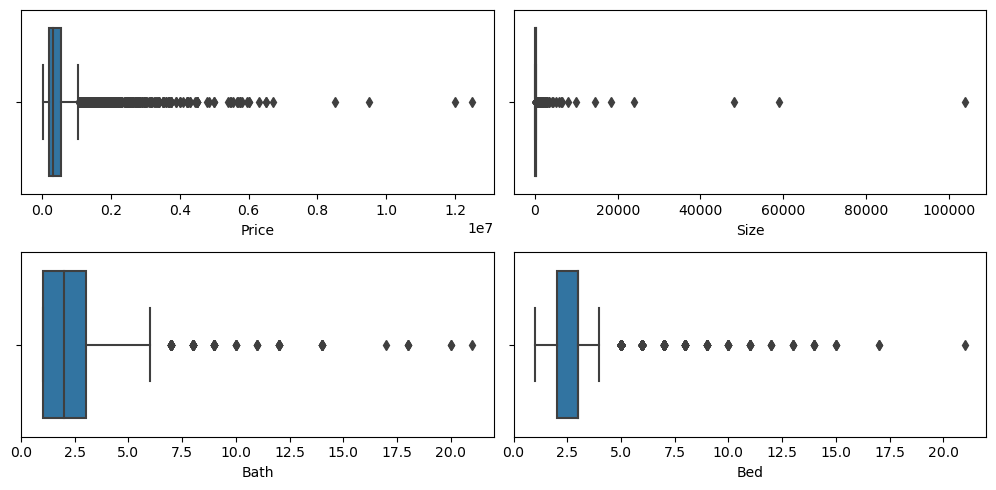

In [20]:
# Outlier Analysis
fig, axs = plt.subplots(2,2, figsize = (10,5))
plt1 = sns.boxplot(df2['Price'], ax = axs[0,0])
plt2 = sns.boxplot(df2['Size'], ax = axs[0,1])
plt1 = sns.boxplot(df2['Bath'], ax = axs[1,0])
plt2 = sns.boxplot(df2['Bed'], ax = axs[1,1])

plt.tight_layout()



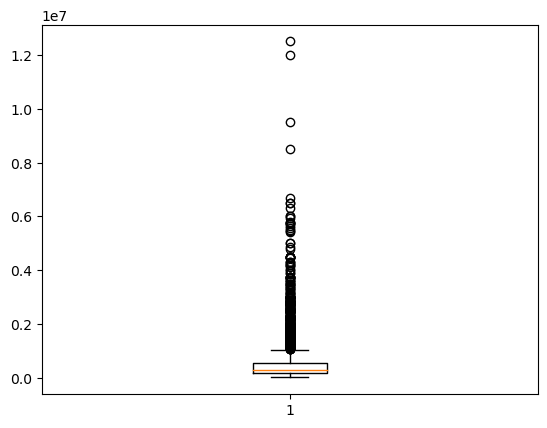

In [21]:
# outlier treatment for Price
plt.boxplot(df2.Price)
Q1 = df2.Price.quantile(0.25)
Q3 = df2.Price.quantile(0.75)
IQR = Q3 - Q1
df2 = df2[(df2.Price >= Q1 - 1.5*IQR) & (df2.Price <= Q3 + 1.5*IQR)]



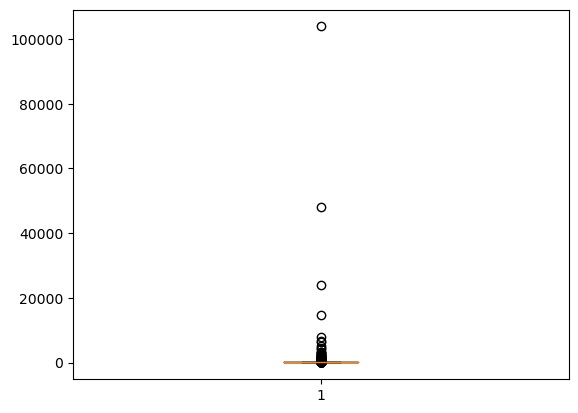

In [22]:
# outlier treatment for Size
plt.boxplot(df2.Size)
Q1 = df2.Size.quantile(0.25)
Q3 = df2.Size.quantile(0.75)
IQR = Q3 - Q1
df2 = df2[(df2.Size >= Q1 - 1.5*IQR) & (df2.Size <= Q3 + 1.5*IQR)]



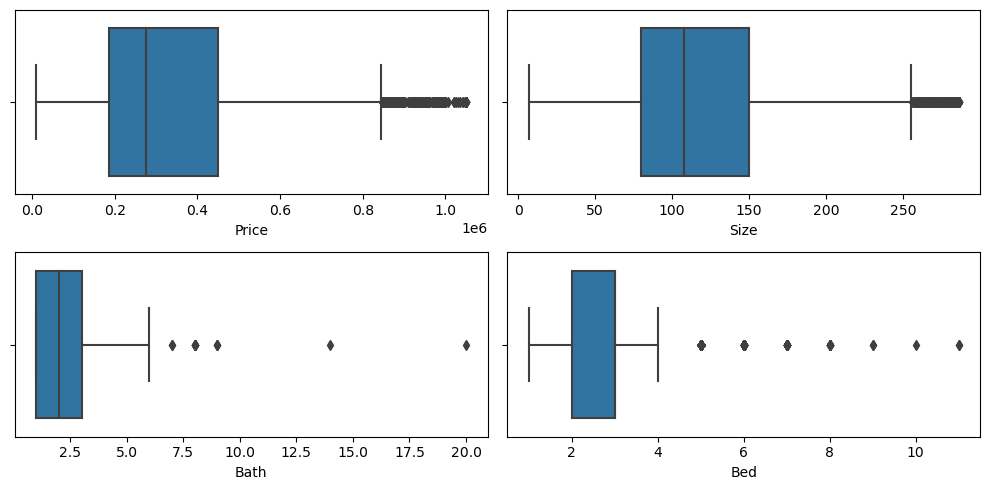

In [23]:
# Outlier Analysis
fig, axs = plt.subplots(2,2, figsize = (10,5))
plt1 = sns.boxplot(df2['Price'], ax = axs[0,0])
plt2 = sns.boxplot(df2['Size'], ax = axs[0,1])
plt1 = sns.boxplot(df2['Bath'], ax = axs[1,0])
plt2 = sns.boxplot(df2['Bed'], ax = axs[1,1])

plt.tight_layout()



In [24]:
df2.describe()

,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,Monthly_Profit
count,8.230000e+03,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000
mean,3.414544e+05,120.189429,2.043013,2.624180,0.045808,0.198542,0.566586,0.062697,0.078493,-829.577018
std,2.130198e+05,54.689708,1.038028,1.058881,0.209081,0.398927,0.495577,0.242433,0.268963,1226.654923
min,1.000000e+04,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5646.110881
25%,1.850000e+05,80.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1358.662886
50%,2.750000e+05,108.000000,2.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-534.224251
75%,4.490000e+05,150.000000,3.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-53.774573
max,1.050000e+06,286.000000,20.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2400.282925


In [25]:
df2.drop(df2[(df2.Size ==1)].index, inplace=True)
df2.describe()



,Price,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,Monthly_Profit
count,8.230000e+03,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000
mean,3.414544e+05,120.189429,2.043013,2.624180,0.045808,0.198542,0.566586,0.062697,0.078493,-829.577018
std,2.130198e+05,54.689708,1.038028,1.058881,0.209081,0.398927,0.495577,0.242433,0.268963,1226.654923
min,1.000000e+04,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5646.110881
25%,1.850000e+05,80.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1358.662886
50%,2.750000e+05,108.000000,2.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-534.224251
75%,4.490000e+05,150.000000,3.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-53.774573
max,1.050000e+06,286.000000,20.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2400.282925


In [54]:
# we want to predict the price , we need the table similar to the rent table we treated
# in Ml we need to delete the target column
dataf = df2.copy()
dataf = dataf.drop(columns = ['Price'])



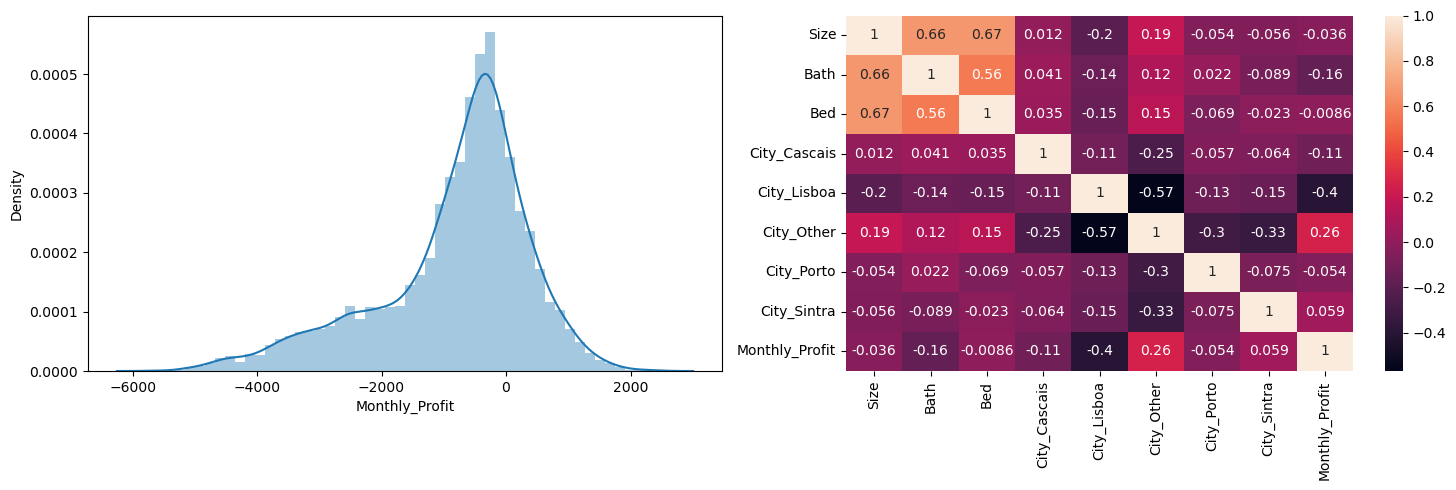

In [55]:
# histogram and heat map
corr = dataf.corr()
fig, axs = plt.subplots(1,2, figsize=[15,5])
sns.distplot(dataf['Monthly_Profit'], ax=axs[0])
sns.heatmap(corr, ax=axs[1], annot=True)
fig.tight_layout()



In [56]:
dataf['good_prop'] = np.where(dataf['Monthly_Profit'] > -400, 1, 0)  # good if monthly expense is less than 300
dataf = dataf.drop(columns = ['Monthly_Profit'])
dataf.head()



,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,good_prop
0,140,2,3,0,0,0,1,0,1
2,152,3,4,0,0,1,0,0,0
4,75,1,2,0,0,1,0,0,1
6,120,4,3,0,0,1,0,0,1
7,149,8,3,0,0,1,0,0,0


In [57]:
dataf.describe()

,Size,Bath,Bed,City_Cascais,City_Lisboa,City_Other,City_Porto,City_Sintra,good_prop
count,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000,8230.000000
mean,120.189429,2.043013,2.624180,0.045808,0.198542,0.566586,0.062697,0.078493,0.431106
std,54.689708,1.038028,1.058881,0.209081,0.398927,0.495577,0.242433,0.268963,0.495261
min,7.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,80.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,108.000000,2.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,150.000000,3.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,286.000000,20.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
dataf.to_csv(r'Buy_Before_MachineLearning.csv', index = False, header=True)

In [59]:
ML = pd.read_csv('Buy_Before_MachineLearning.csv')

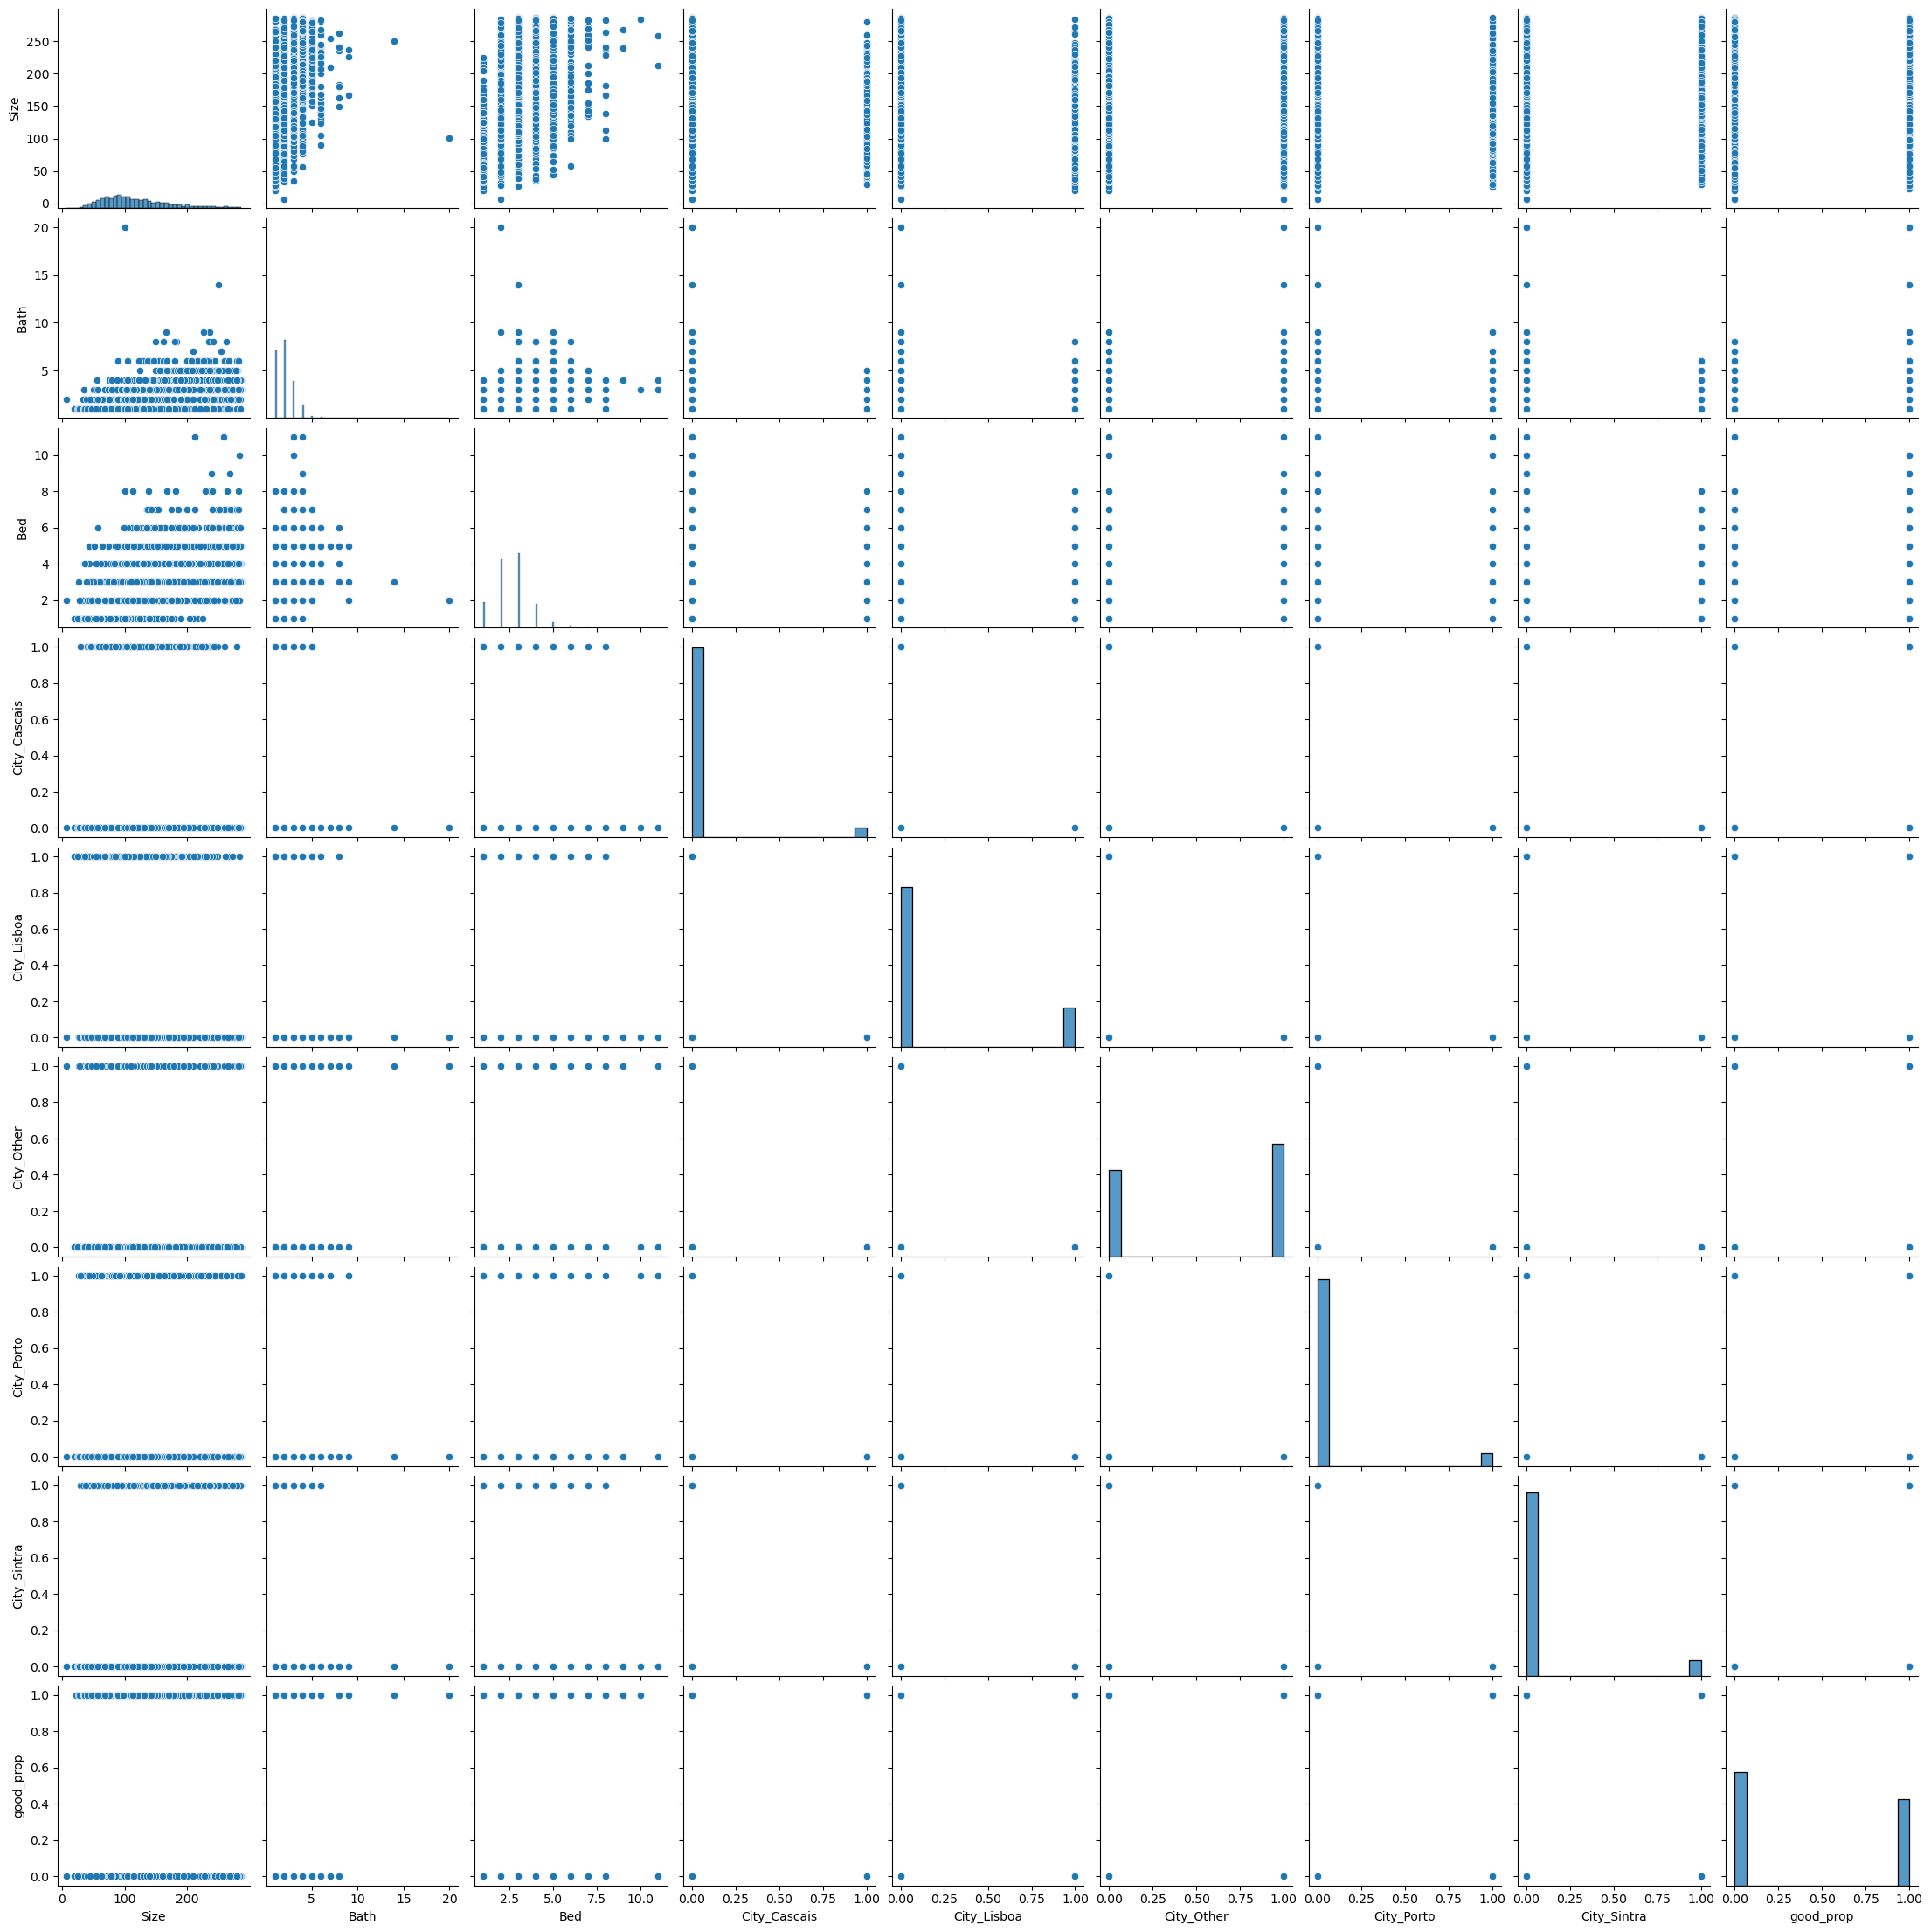

In [61]:
sns.pairplot(ML)
plt.show()



Text(0, 0.5, 'Count')

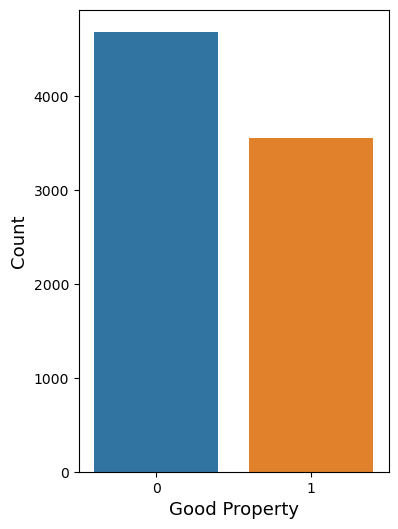

In [62]:
plt.figure(figsize=(4,6))

sns.countplot(x='good_prop', data=ML)
plt.xlabel('Good Property', fontsize=13)
plt.ylabel('Count', fontsize=13)



In [63]:
# Check proportion of minor vs. major
print('not good: {}%'.format(round((ML['good_prop'].value_counts()[0] / ML.shape[0]), 2)*100))
print('good: {}%'.format(round((ML['good_prop'].value_counts()[1] / ML.shape[0]), 2)*100))

not good: 56.99999999999999%
good: 43.0%


# Classification model

In [64]:
X = ML.drop(columns = ['good_prop'])
predictors = X.columns
y = ML['good_prop']

# Logistic Regression


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

z = StandardScaler()
z.fit(X_train[['Size']])  # size is the only continuous var

X_train['Size'] = z.transform(X_train[['Size']])
X_test['Size'] = z.transform(X_test[['Size']])

In [66]:
lr = LogisticRegression()

In [67]:
lr.fit(X_train, y_train)

LogisticRegression()

In [68]:
lr_pred = lr.predict(X_test)

In [69]:
accuracy_score(y_test, lr_pred)

0.675577156743621

In [70]:
precision, recall, fscore, support = score(y_test, lr_pred, average='macro')
print(f'Precision : {precision}')
print(f'Recall    : {recall}')
print(f'F-score   : {fscore}')



Precision : 0.6728428345015767
Recall    : 0.6734363844758536
F-score   : 0.6730750061370686


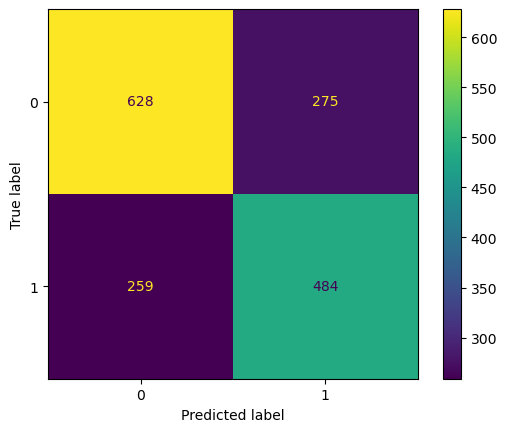

In [71]:
plot_confusion_matrix(lr, X_test, y_test)



In [72]:
# LR Coef interpretation
coef = pd.DataFrame({"Coefs": lr.coef_[0],  #[0] needed for Logistic Regression
                    "Names": predictors})  
coef = coef.append({"Coefs": lr.intercept_[0],  
                    "Names": "intercept"}, ignore_index = True)



In [73]:
# adding odds
coef['Odds Coefs'] = np.exp(coef['Coefs'])
coef



,Coefs,Names,Odds Coefs
0,0.136831,Size,1.146634
1,-0.456937,Bath,0.633220
2,0.153630,Bed,1.166059
3,-3.210683,City_Cascais,0.040329
4,-4.000234,City_Lisboa,0.018311
5,-1.841531,City_Other,0.158574
6,-3.271691,City_Porto,0.037942
7,-1.852490,City_Sintra,0.156846
8,2.458538,intercept,11.687708


In [74]:
ypred_prob = lr.predict_proba(X)

In [75]:
ypred_prob1 = ypred_prob[:, 1]

In [76]:
thresh = 0.5

ypred_prob_thresh = (ypred_prob1 > thresh) * 1
accuracy_score(y, ypred_prob_thresh)



0.43110571081409477

In [77]:
# regularization

lr_reg = LogisticRegression(penalty = 'none')
lr_reg.fit(X_train, y_train)



LogisticRegression(penalty='none')

In [78]:
lr_reg_pred = lr_reg.predict(X_test)
accuracy_score(y_test, lr_reg_pred)



0.6761846901579587

# Decision Tree


In [79]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)



DecisionTreeClassifier()

In [80]:
tree_pred = tree.predict(X_test)

accuracy_score(y_test, tree_pred)



0.6688942891859052

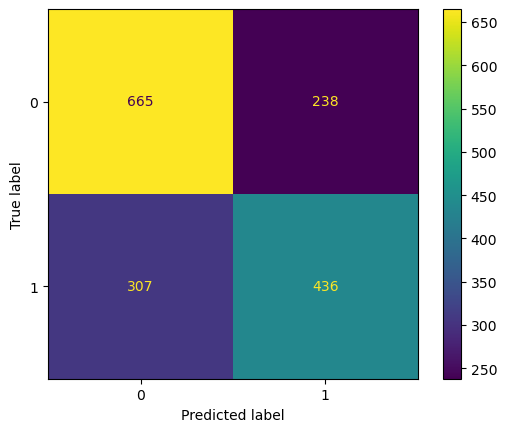

In [81]:
plot_confusion_matrix(tree, X_test, y_test)

In [82]:
tree.get_depth()

34

In [83]:
tree.get_n_leaves()

1514

In [84]:
# reducing tree depth
tree15 = DecisionTreeClassifier(max_depth =15)
tree15.fit(X_train, y_train)
tree15_pred = tree.predict(X_test)
accuracy_score(y_test, tree15_pred)



0.6688942891859052

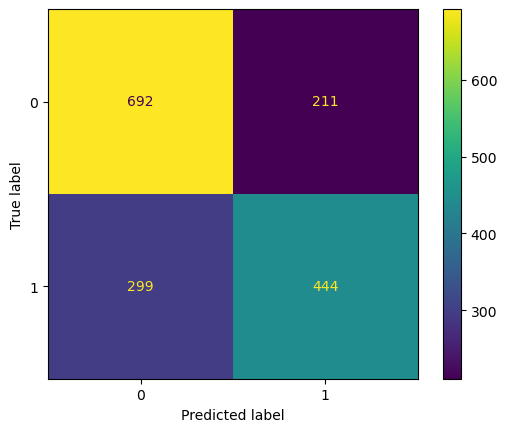

In [85]:
plot_confusion_matrix(tree15, X_test, y_test)

In [86]:
tree15.feature_importances_

array([0.45605606, 0.09453431, 0.07960308, 0.04538458, 0.2061058 ,
       0.02344535, 0.05938437, 0.03548644])


# Model Comparison

Testing 6 different algorithms:

Logistic Regression (LR)

K-Nearest Neighbors (KNN)

Random Forest (RF)

Decision Trees (DT)

Gaussian Naive Bayes (NB)

Support Vector Machines (SVM)


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

z = StandardScaler()
z.fit(X_train[['Size']])  # size is the only continuous var

X_train['Size'] = z.transform(X_train[['Size']])
X_test['Size'] = z.transform(X_test[['Size']])

In [88]:
# Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(probability=True)))
models.append(('XGBoost', XGBClassifier(eval_metric='logloss')))

# Evaluate each model
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))



LR: 0.675424 (0.015754)
KNN: 0.680132 (0.015753)
RF: 0.668433 (0.015113)
DT: 0.663574 (0.016089)
NB: 0.642928 (0.014347)
SVM: 0.680135 (0.016094)
XGBoost: 0.679375 (0.011989)


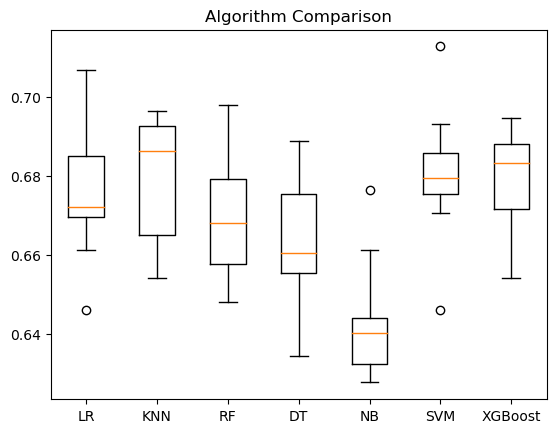

In [89]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()



In [90]:
# Create list of model and accuracy dicts
summaryList = []

# List for storing scores
scores = []



In [91]:
# function to evaluate model and store scores

def model_eval(algorithm, name, X_train, y_train):

    class_model = algorithm

    # Calculate accuracy of train
    acc = cross_val_score(class_model, X_train, y_train).mean()

    class_model.fit(X_train, y_train)

    # Get predictions and probabilities
    y_preds = class_model.predict(X_test)
    y_score = class_model.predict_proba(X_test)

    # Calculate accuracy of test
    acc_test = round(accuracy_score(y_test, y_preds), 3)

    # Get precision, recall, f1-score
    precision, recall, fscore, support = score(y_test, y_preds, average='macro')

    # Add model and accuracy dict to list
    summaryList.append(dict([
        ('Model', name),
        ('Train Accuracy', round(acc, 3)),
        ('Test Accuracy', acc_test),
        ('Precision', round(precision, 3)),
        ('Recall', round(recall, 3)),
        ('F1', round(fscore, 3))
         ]))

    # Add y_score to list
    scores.append(y_score)



In [92]:
model_eval(LogisticRegression(), 'LR', X_train, y_train)
model_eval(KNeighborsClassifier(), 'KNN', X_train, y_train)
model_eval(RandomForestClassifier(), 'Random Forest', X_train, y_train)
model_eval(DecisionTreeClassifier(), 'Dec Tree', X_train, y_train)
model_eval(GaussianNB(), 'Gaussian NB', X_train, y_train)
model_eval(SVC(probability=True), 'SVM', X_train, y_train)
model_eval(XGBClassifier(eval_metric='auc'), 'XGBoost', X_train, y_train)

In [94]:
model_summary = pd.DataFrame(data=summaryList)
model_summary = model_summary[['Model', 'Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_summary.drop_duplicates(inplace=True)
model_summary



,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1
0,LR,0.677,0.703,0.701,0.705,0.701
1,KNN,0.683,0.689,0.683,0.682,0.682
2,Random Forest,0.681,0.676,0.670,0.669,0.669
3,Dec Tree,0.669,0.668,0.661,0.656,0.658
4,Gaussian NB,0.643,0.665,0.714,0.691,0.661
5,SVM,0.675,0.716,0.715,0.718,0.714
6,XGBoost,0.683,0.695,0.689,0.686,0.687


In [95]:
def plot_roc_curves():
    plt.figure(figsize=(10,6))
    lw = 2
    
    # Logistic Regression
    fpr, tpr, thresholds = roc_curve(y_test, scores[0][:,1], pos_label=1)
    auc_lr = roc_auc_score(y_test, scores[0][:,1])
    plt.plot(fpr, tpr, color='r',
             lw=lw, label='LR, AUC=%.3f' % auc_lr)
        
    # KNN
    fpr, tpr, thresholds = roc_curve(y_test, scores[1][:,1], pos_label=1)
    auc_knn = roc_auc_score(y_test, scores[1][:,1])
    plt.plot(fpr, tpr, color='y',
             lw=lw, label='KNN, AUC=%.3f' % auc_knn)
    
    # Random Forest
    fpr, tpr, thresholds = roc_curve(y_test, scores[2][:,1], pos_label=1)
    auc_rf = roc_auc_score(y_test, scores[2][:,1])
    plt.plot(fpr, tpr, color='b',
             lw=lw, label='Random Forest, AUC=%.3f' % auc_rf)
    
    # Decision Tree
    fpr, tpr, thresholds = roc_curve(y_test, scores[3][:,1], pos_label=1)
    auc_dt = roc_auc_score(y_test, scores[3][:,1])
    plt.plot(fpr, tpr, color='g',
             lw=lw, label='Decision Tree, AUC=%.3f' % auc_dt)
    
    # Gaussian NB
    fpr, tpr, thresholds = roc_curve(y_test, scores[4][:,1], pos_label=1)
    auc_nb = roc_auc_score(y_test, scores[4][:,1])
    plt.plot(fpr, tpr, color='c',
             lw=lw, label='Gaussian NB, AUC=%.3f' % auc_nb)
    
    # SVM
    fpr, tpr, thresholds = roc_curve(y_test, scores[5][:,1], pos_label=1)
    auc_svm = roc_auc_score(y_test, scores[5][:,1])
    plt.plot(fpr, tpr, color='m',
             lw=lw, label='SVM, AUC=%.3f' % auc_svm)    
    
    # XGBoost
    fpr, tpr, thresholds = roc_curve(y_test, scores[6][:,1], pos_label=1)
    auc_xgb = roc_auc_score(y_test, scores[6][:,1])
    plt.plot(fpr, tpr, color='lime',
             lw=lw, label='XGBoost, AUC=%.3f' % auc_xgb)
    
    
    # Formatting
    plt.plot([0, 1], [0, 1], color='k', lw=lw, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve', fontsize=12)
    plt.legend(loc="lower right")
    plt.show()



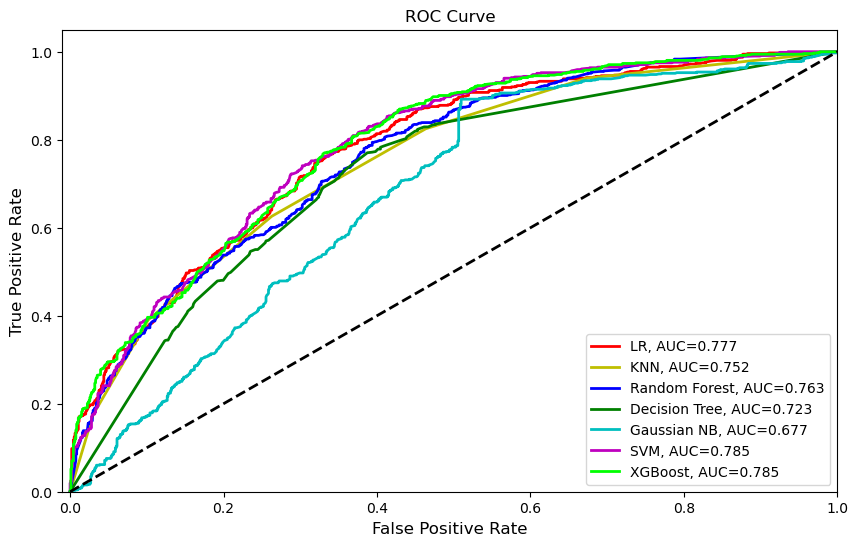

In [96]:
plot_roc_curves()